In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

batch1 = pickle.load(open(r'.\Data\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())


# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2 = pickle.load(open(r'.\Data\batch2.pkl','rb'))
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())


batch3 = pickle.load(open(r'.\Data\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

numBat3 = len(batch3.keys())


numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

# Train and Test Split
# If you are interested in using the same train/test split as the paper, use the indices specified below
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);


# Data Preprocessing
import random
random.seed(42)
shuffled_keys = list(bat_dict.keys())
random.shuffle(shuffled_keys)

max_length = max(len(bat_dict[key]['summary']['QD']) for key in bat_dict.keys())

train_dataset = []
primary_test_dataset = []
secondary_test_dataset = []

# For train dataset
visible = 300 # Initial visible cycle 
for i, key in enumerate(bat_dict.keys()):
    if i in train_ind:
        if len(bat_dict[key]['summary']['QD'][1:]) < visible:
            continue
        else:
            train_dataset.append(bat_dict[key]['summary']['QD'][1:])
    elif i in test_ind:        
        if len(bat_dict[key]['summary']['QD'][1:]) < visible: 
            continue
        else:
            primary_test_dataset.append(bat_dict[key]['summary']['QD'][1:])
    elif i in secondary_test_ind:        
        if len(bat_dict[key]['summary']['QD'][1:]) < visible: 
            continue
        else:
            secondary_test_dataset.append(bat_dict[key]['summary']['QD'][1:])

In [2]:
len(train_dataset), len(primary_test_dataset), len(secondary_test_dataset)

(41, 42, 40)

In [3]:
train_ind, test_ind, secondary_test_ind

(array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]),
 array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123]))

Text(0.5, 1.0, 'Before Median Filter')

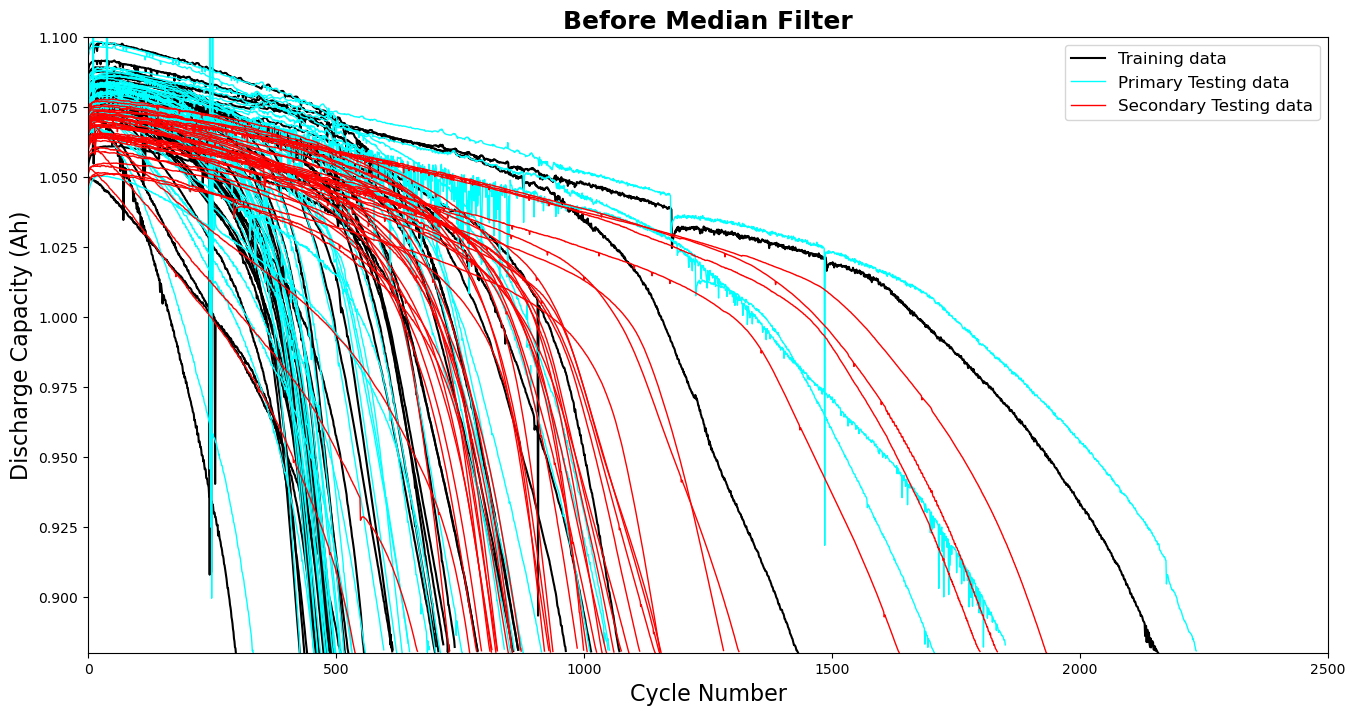

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(16, 8))
for i in range(len(train_dataset)):
    if i == 0:
        ax.plot(range(len(train_dataset[i])), train_dataset[i], color='black', lw='1.5', label='Training data')
    else:
        ax.plot(range(len(train_dataset[i])), train_dataset[i], color='black', lw='1.5')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Capacity')
    ax.set_ylim(0.88, 1.1)
    ax.legend()
for i in range(len(primary_test_dataset)):
    if i == 0:
        ax.plot(range(len(primary_test_dataset[i])), primary_test_dataset[i], color='cyan', lw='1.0', label='Primary Testing data')
    else:
        ax.plot(range(len(primary_test_dataset[i])), primary_test_dataset[i], color='cyan', lw='1.0')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Capacity')
    ax.set_ylim(0.88, 1.1)
    ax.legend()
for i in range(len(secondary_test_dataset)):    
    if i == 0:
        ax.plot(range(len(secondary_test_dataset[i])), secondary_test_dataset[i], color='red', lw='1.0', label='Secondary Testing data')
    else:
        ax.plot(range(len(secondary_test_dataset[i])), secondary_test_dataset[i], color='red', lw='1.0')
    ax.set_xlabel('Cycle Number', fontsize=16)
    ax.set_ylabel('Discharge Capacity (Ah)', fontsize=16)
    ax.set_ylim(0.88, 1.1)
    ax.set_xlim(0, 2500)
    ax.legend(fontsize=12)
ax.set_title('Before Median Filter', fontsize=18,  weight='bold')

# plt.savefig('Before Median Filter', format='png', dpi=300)  # Saves the figure as a PNG file with 300 DPI


In [5]:
# Zero padding below 0.88 Ah and Median Filter
import scipy.signal
from scipy.signal import medfilt
ks = 51
    
for i in range(len(train_dataset)):
    train_dataset[i] = np.append(scipy.signal.medfilt(train_dataset[i], kernel_size=ks), [0.0] * (max_length - len(train_dataset[i])))
    where_not_eol = train_dataset[i] > 0.88
    train_dataset[i] = train_dataset[i] * where_not_eol
for i in range(len(primary_test_dataset)):
    primary_test_dataset[i] = np.append(scipy.signal.medfilt(primary_test_dataset[i], kernel_size=ks), [0.0] * (max_length - len(primary_test_dataset[i])))
    where_not_eol = primary_test_dataset[i] > 0.88
    primary_test_dataset[i] = primary_test_dataset[i] * where_not_eol
for i in range(len(secondary_test_dataset)):
    secondary_test_dataset[i] = np.append(scipy.signal.medfilt(secondary_test_dataset[i], kernel_size=ks), [0.0] * (max_length - len(secondary_test_dataset[i])))
    where_not_eol = secondary_test_dataset[i] > 0.88
    secondary_test_dataset[i] = secondary_test_dataset[i] * where_not_eol

Text(0.5, 1.0, 'After Median Filter')

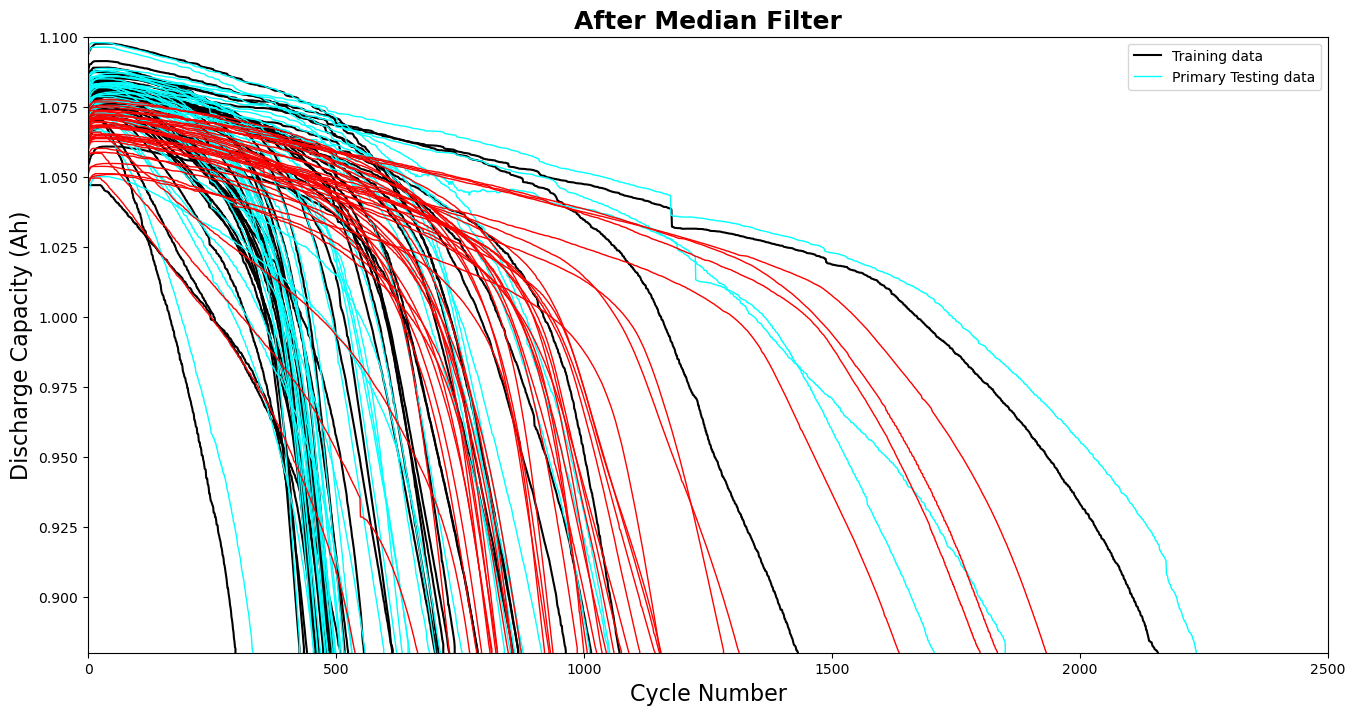

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(16, 8))
for i in range(len(train_dataset)):
    if i == 0:
        ax.plot(range(len(train_dataset[i])), train_dataset[i], color='black', lw='1.5', label='Training data')
    else:
        ax.plot(range(len(train_dataset[i])), train_dataset[i], color='black', lw='1.5')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Capacity')
    ax.set_ylim(0.88, 1.1)
    ax.legend()
for i in range(len(primary_test_dataset)):
    if i == 0:
        ax.plot(range(len(primary_test_dataset[i])), primary_test_dataset[i], color='cyan', lw='1.0', label='Primary Testing data')
    else:
        ax.plot(range(len(primary_test_dataset[i])), primary_test_dataset[i], color='cyan', lw='1.0')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Capacity')
    ax.set_title('Train Profiles')
    ax.set_ylim(0.88, 1.1)
    ax.legend()
for i in range(len(secondary_test_dataset)):    
    if i == 0:
        ax.plot(range(len(secondary_test_dataset[i])), secondary_test_dataset[i], color='red', lw='1.0', label='Secondary Testing data')
    else:
        ax.plot(range(len(secondary_test_dataset[i])), secondary_test_dataset[i], color='red', lw='1.0')
    ax.set_xlabel('Cycle Number', fontsize=16)
    ax.set_ylabel('Discharge Capacity (Ah)', fontsize=16)
    ax.set_title('Train Profiles')
    ax.set_ylim(0.88, 1.1)
    ax.set_xlim(0, 2500)
ax.set_title('After Median Filter', fontsize=18,  weight='bold')

# plt.savefig('After Median Filter', format='png', dpi=300)  # Saves the figure as a PNG file with 300 DPI

In [7]:
# Check data End of Life (EOL) Cycle 
for i in range(len(train_dataset)):
    print('train', i, np.where(train_dataset[i] == 0)[0][0])
for i in range(len(primary_test_dataset)):
    print('primary', np.where(primary_test_dataset[i] == 0)[0][0])
for i in range(len(secondary_test_dataset)):
    print('secondary', np.where(secondary_test_dataset[i] == 0)[0][0])

train 0 2158
train 1 1432
train 2 1072
train 3 868
train 4 786
train 5 717
train 6 855
train 7 786
train 8 557
train 9 1015
train 10 868
train 11 858
train 12 707
train 13 729
train 14 740
train 15 702
train 16 615
train 17 964
train 18 700
train 19 614
train 20 298
train 21 436
train 22 442
train 23 509
train 24 475
train 25 481
train 26 492
train 27 459
train 28 487
train 29 525
train 30 459
train 31 466
train 32 496
train 33 490
train 34 518
train 35 461
train 36 476
train 37 457
train 38 427
train 39 460
train 40 485
primary 1850
primary 2235
primary 1707
primary 634
primary 1052
primary 878
primary 860
primary 689
primary 532
primary 1012
primary 852
primary 840
primary 915
primary 874
primary 755
primary 701
primary 646
primary 623
primary 1049
primary 649
primary 597
primary 333
primary 478
primary 559
primary 456
primary 483
primary 485
primary 500
primary 511
primary 493
primary 469
primary 508
primary 479
primary 517
primary 497
primary 533
primary 463
primary 497
primary 464

In [8]:
import torch

## Prepare (x, y) dataset for initial 300 cycles with zero padding
size = len(train_dataset[0]) # max cycle dimension 
train_visible_dataset_x = []
train_visible_dataset_y = []
primary_visible_dataset_x = []
primary_visible_dataset_y = []
secondary_visible_dataset_x = []
secondary_visible_dataset_y = []

for i in range(len(train_dataset)):
    train_visible_dataset_x.append(np.append(train_dataset[i][:visible], [0.0]*(size-visible)))
    train_visible_dataset_y.append(np.array([np.where(train_dataset[i] == 0)[0][0]], dtype=np.float64))

for i in range(len(primary_test_dataset)):
    primary_visible_dataset_x.append(np.append(primary_test_dataset[i][:visible], [0.0]*(size-visible)))
    primary_visible_dataset_y.append(np.array([np.where(primary_test_dataset[i] == 0)[0][0]], dtype=np.float64))
    
for i in range(len(secondary_test_dataset)):
    secondary_visible_dataset_x.append(np.append(secondary_test_dataset[i][:visible], [0.0]*(size-visible)))
    secondary_visible_dataset_y.append(np.array([np.where(secondary_test_dataset[i] == 0)[0][0]], dtype=np.float64))    
    
## Numpy to Torch
for i, ts in enumerate(train_visible_dataset_x):
    train_visible_dataset_x[i] = torch.from_numpy(ts).reshape(1,-1)

for i, ts in enumerate(primary_visible_dataset_x):
    primary_visible_dataset_x[i] = torch.from_numpy(ts).reshape(1,-1)

for i, ts in enumerate(secondary_visible_dataset_x):
    secondary_visible_dataset_x[i] = torch.from_numpy(ts).reshape(1,-1)

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
import copy
from torch.utils.data import TensorDataset, DataLoader


## Similarity-based prediction
case = 'cos' # similarity criterion = 'l2', 'cos'
train_data_loader = []
secondary_data_loader = []
train_min_indices = []
primary_min_indices = []
secondary_min_indices = []
train_expected_eol_cycle = []
train_error_cycle = []
train_percentage_error = []
primary_expected_eol_cycle = []
primary_error_cycle = []
primary_percentage_error = []
secondary_expected_eol_cycle = []
secondary_error_cycle = []
secondary_percentage_error = []
total_train_avg_error = []
total_train_std_error = []
total_primary_avg_error = []
total_primary_std_error = []
total_secondary_avg_error = []
total_secondary_std_error = []
total_train_rmse = []
total_primary_rmse = []
total_secondary_rmse = []
bs = 128

norm_method = 'robust' # Normalization method = 'minimax', 'standard', 'robust'
norm_scale = 1 # normalization scale: -n ~ n
n_sigma = 1.0 # n-sigma for training data generalization

upper_quantile = 0.75
lower_quantile = 0.25

train_samples = train_dataset
train_data_x = train_visible_dataset_x
train_data_y = train_visible_dataset_y
primary_data_x = primary_visible_dataset_x
primary_data_y = primary_visible_dataset_y
secondary_data_x = secondary_visible_dataset_x
secondary_data_y = secondary_visible_dataset_y

# Fin the min_l2, max_l2 in the training dataset for normalization
candidate = []
for i, train_one in enumerate(train_data_x): 
    for j, train_two in enumerate(train_data_x):
        if i == j: continue
        candidate.append(torch.dist(train_one, train_two, p=2))

values_tensor = torch.stack(candidate)
mean_l2_value = torch.mean(values_tensor)
min_l2_value = torch.min(values_tensor)
max_l2_value = torch.max(values_tensor)

# Fin the min_cos, max_cos in the training dataset for normalization
candidate = []
for i, train_one in enumerate(train_data_x): 
    for j, train_two in enumerate(train_data_x):
        if i == j: continue
        candidate.append(F.cosine_similarity(train_one, train_two))

values_tensor = torch.stack(candidate)
mean_cos_value = torch.mean(values_tensor)
min_cos_value = torch.min(values_tensor)
max_cos_value = torch.max(values_tensor)

tensors_x, tensors_y = [], []

if case == 'l2' or case == 'cos': 
    
    # Similarity-based initial prediction (candidates for primary testing dataset)
    primary_sample_errors = [[] for _ in range(len(primary_data_x))]
    for i, test_sample in enumerate(primary_data_x):
        for j, train_sample in enumerate(train_data_x):
            l2 = torch.dist(test_sample[0][:visible], train_sample[0][:visible], p=2)
            cos = F.cosine_similarity(test_sample[0][:visible].reshape(1,-1), train_sample[0][:visible].reshape(1,-1))
        
            if case == 'l2':
                primary_sample_errors[i].append(l2)
            elif case == 'cos':
                primary_sample_errors[i].append(1.0 - cos)

    for i, sample_errors in enumerate(primary_sample_errors):
        sample_errors = torch.stack(sample_errors)
        min_index = torch.argmin(sample_errors).item()
        primary_min_indices.append(min_index)
        primary_expected_eol_cycle.append(copy.deepcopy(train_data_y[min_index]))

    # Similarity-based initial prediction (candidates for secondary testing dataset)
    secondary_sample_errors = [[] for _ in range(len(secondary_data_x))]
    for i, test_sample in enumerate(secondary_data_x):
        for j, train_sample in enumerate(train_data_x):
            l2 = torch.dist(test_sample[0][:visible], train_sample[0][:visible], p=2)
            cos = F.cosine_similarity(test_sample[0][:visible].reshape(1,-1), train_sample[0][:visible].reshape(1,-1))
        
            if case == 'l2':
                secondary_sample_errors[i].append(l2)
            elif case == 'cos':
                secondary_sample_errors[i].append(1.0 - cos)

    for i, sample_errors in enumerate(secondary_sample_errors):
        sample_errors = torch.stack(sample_errors)
        min_index = torch.argmin(sample_errors).item()
        secondary_min_indices.append(min_index)
        secondary_expected_eol_cycle.append(copy.deepcopy(train_data_y[min_index]))

    min_train_dist_err = []
    total_train_dist_err = []
        
    # Similarity-based initial prediction (candidates for training dataset),
    # and prepare the training dataset for NNs training 
    for i, train_one in enumerate(train_data_x):
        errors = []
        for j, train_two in enumerate(train_data_x):
            # Be cautious about the order of i, j for data_x and data_y
            l2 = torch.dist(train_one[0][:visible], train_two[0][:visible], p=2)
            cos = F.cosine_similarity(train_one[0][:visible].reshape(1,-1), train_two[0][:visible].reshape(1,-1))

            if case == 'l2':
                errors.append((l2, j))
            elif case == 'cos':
                errors.append((1.0 - cos, j))

        # the magnitude of error (weight) is computed for the weighted loss function in NNs training 
        sorted_errors = sorted(errors, key=lambda x:x[0])
        for num, tpl in enumerate(sorted_errors):
            diff = np.where(train_samples[tpl[1]] == 0)[0][0] - np.where(train_samples[i] == 0)[0][0]
            err = 100 * abs(diff) / np.where(train_samples[i] == 0)[0][0]

            if err == 0.0:
                continue
            elif num == 1:
                min_index = tpl[1]
                train_min_indices.append(min_index)
                min_train_dist_err.append(err)
                train_expected_eol_cycle.append(copy.deepcopy(train_data_y[min_index]))
            total_train_dist_err.append(err)     
            data_x = torch.from_numpy((train_samples[i][:visible] - train_samples[tpl[1]][:visible]))
            data_y1 = torch.from_numpy(np.array([(np.where(train_samples[tpl[1]] == 0)[0][0] - np.where(train_samples[i] == 0)[0][0])], \
                                                        dtype=np.float64))
            data_y2 = torch.from_numpy(np.array([1/(err+1e-8)], dtype=np.float64))
            tensors_x.append(data_x)
            tensors_y.append((data_y1, data_y2)) 
        
    ## Print train/primary/secondary errors
    for i in range(len(train_data_y)):
        train_error_cycle.append(train_expected_eol_cycle[i] - train_data_y[i])
        train_percentage_error.append(abs(train_error_cycle[i]/train_data_y[i]) * 100) 
    mean = np.mean([arr for arr in train_percentage_error])
    std = np.std([arr for arr in train_percentage_error])     
    train_square_mean = np.mean([err**2 for err in train_error_cycle])
    train_sqrt = np.sqrt(train_square_mean)
    
    print('Total Train Avg Error:', round(mean, 2), '[%]')
    print('Total Train Std of Errors:', round(std, 2), '[%]')
    print('Total Train RMSE Error:', round(train_sqrt, 0), '[cycles]\n')
    total_train_avg_error.append(mean)
    total_train_std_error.append(std)
    total_train_rmse.append(train_sqrt) 

    for i in range(len(primary_data_y)):
        primary_error_cycle.append(primary_expected_eol_cycle[i] - primary_data_y[i])
        primary_percentage_error.append(abs(primary_error_cycle[i]/primary_data_y[i]) * 100)
    primary_mean = np.mean([arr for arr in primary_percentage_error])
    primary_std = np.std([arr for arr in primary_percentage_error])
    primary_square_mean = np.mean([err**2 for err in primary_error_cycle])
    primary_sqrt = np.sqrt(primary_square_mean)
    print('Total Primary Avg Error:', round(primary_mean, 2), '[%]')
    print('Total Primary Std of Errors:', round(primary_std, 2), '[%]')
    print('Total Primary RMSE Error:', round(primary_sqrt, 0), '[cycles]\n')
    total_primary_avg_error.append(primary_mean)
    total_primary_std_error.append(primary_std)
    total_primary_rmse.append(primary_sqrt)
    
    for i in range(len(secondary_data_y)):
        secondary_error_cycle.append(secondary_expected_eol_cycle[i] - secondary_data_y[i])
        secondary_percentage_error.append(abs(secondary_error_cycle[i]/secondary_data_y[i]) * 100) 
    secondary_mean = np.mean([arr for arr in secondary_percentage_error])
    secondary_std = np.std([arr for arr in secondary_percentage_error]) 
    secondary_square_mean = np.mean([err**2 for err in secondary_error_cycle])
    secondary_sqrt = np.sqrt(secondary_square_mean)           
    print('Total Secondary Avg Error:', round(secondary_mean, 2), '[%]')
    print('Total Secondary secondary_std of Errors:', round(secondary_std, 2), '[%]')
    print('Total Secondary RMSE Error:', round(secondary_sqrt, 0), '[cycles]\n')
    total_secondary_avg_error.append(secondary_mean)
    total_secondary_std_error.append(secondary_std)
    total_secondary_rmse.append(secondary_sqrt)
  
    for i, c in enumerate(primary_percentage_error):
        print('error cycle of primary sample {}: '.format(i), c[0], '[%]')

Total Train Avg Error: 12.41 [%]
Total Train Std of Errors: 15.39 [%]
Total Train RMSE Error: 186.0 [cycles]

Total Primary Avg Error: 9.66 [%]
Total Primary Std of Errors: 10.55 [%]
Total Primary RMSE Error: 116.0 [cycles]

Total Secondary Avg Error: 22.09 [%]
Total Secondary secondary_std of Errors: 30.44 [%]
Total Secondary RMSE Error: 377.0 [cycles]

error cycle of primary sample 0:  22.594594594594593 [%]
error cycle of primary sample 1:  3.4451901565995526 [%]
error cycle of primary sample 2:  16.11013473930873 [%]
error cycle of primary sample 3:  22.71293375394322 [%]
error cycle of primary sample 4:  18.726235741444867 [%]
error cycle of primary sample 5:  18.337129840546698 [%]
error cycle of primary sample 6:  16.627906976744185 [%]
error cycle of primary sample 7:  23.802612481857764 [%]
error cycle of primary sample 8:  16.917293233082706 [%]
error cycle of primary sample 9:  0.2964426877470355 [%]
error cycle of primary sample 10:  13.145539906103288 [%]
error cycle of pr

In [10]:
## Make training dataset for NNs training             
train_tensors_x = torch.stack(tensors_x)
train_tensors_y = torch.stack([ts[0] for ts in tensors_y])
train_tensors_y2 = torch.stack([ts[1] for ts in tensors_y])

median_tensor_x = torch.median(train_tensors_x)
iqr_tensor_x = torch.quantile(train_tensors_x, upper_quantile) - torch.quantile(train_tensors_x, lower_quantile)
train_tensors_x = (train_tensors_x - median_tensor_x) / iqr_tensor_x

median_tensor_y = torch.median(train_tensors_y)
iqr_tensor_y = torch.quantile(train_tensors_y, upper_quantile) - torch.quantile(train_tensors_y, lower_quantile)
train_tensors_y = (train_tensors_y - median_tensor_y) / iqr_tensor_y

train_tensors_dataset = TensorDataset(train_tensors_x.float(), train_tensors_y.float(), train_tensors_y2.float())
train_data_loader = DataLoader(train_tensors_dataset, batch_size=bs, shuffle=True)


## Make train dataset for correction factor validation
train_estimated_for_valid_x = [(train_data_x[idx].squeeze()[:visible] - train_data_x[i].squeeze()[:visible]) for i, idx in enumerate(train_min_indices)]
train_estimated_for_valid_x = [(sample - median_tensor_x) / iqr_tensor_x for sample in train_estimated_for_valid_x]
train_estimated_for_valid_y = [torch.from_numpy(train_data_y[i] - train_data_y[idx]) for i, idx in enumerate(train_min_indices)]
train_estimated_for_valid_y = [torch.tensor([(sample - median_tensor_y) / iqr_tensor_y]) for sample in train_estimated_for_valid_y]
train_tensors_for_valid_x = torch.stack(train_estimated_for_valid_x)
train_tensors_for_valid_y = torch.stack(train_estimated_for_valid_y)
train_tensors_dataset_for_valid = TensorDataset(train_tensors_for_valid_x.float(), train_tensors_for_valid_y.float())
train_data_loader_for_valid = DataLoader(train_tensors_dataset_for_valid, batch_size=bs, shuffle=False)


## Make primary dataset for correction factor
primary_estimated_x = [(train_data_x[idx].squeeze()[:visible] - primary_data_x[i].squeeze()[:visible]) for i, idx in enumerate(primary_min_indices)]
primary_estimated_x = [(sample - median_tensor_x) / iqr_tensor_x for sample in primary_estimated_x]
primary_estimated_y = [torch.from_numpy(primary_data_y[i] - train_data_y[idx]) for i, idx in enumerate(primary_min_indices)]
primary_estimated_y = [torch.tensor([(sample - median_tensor_y) / iqr_tensor_y]) for sample in primary_estimated_y]
primary_tensors_x = torch.stack(primary_estimated_x)
primary_tensors_y = torch.stack(primary_estimated_y)
primary_tensors_dataset = TensorDataset(primary_tensors_x.float(), primary_tensors_y.float())
primary_data_loader = DataLoader(primary_tensors_dataset, batch_size=bs, shuffle=False)


## Make test dataset for correction factor
secondary_estimated_x = [(train_data_x[idx].squeeze()[:visible] - secondary_data_x[i].squeeze()[:visible]) for i, idx in enumerate(secondary_min_indices)]
secondary_estimated_x = [(sample - median_tensor_x) / iqr_tensor_x for sample in secondary_estimated_x]
secondary_estimated_y = [torch.from_numpy(secondary_data_y[i] - train_data_y[idx]) for i, idx in enumerate(secondary_min_indices)]
secondary_estimated_y = [torch.tensor([(sample - median_tensor_y) / iqr_tensor_y]) for sample in secondary_estimated_y]
secondary_tensors_x = torch.stack(secondary_estimated_x)
secondary_tensors_y = torch.stack(secondary_estimated_y)
secondary_tensors_dataset = TensorDataset(secondary_tensors_x.float(), secondary_tensors_y.float())
secondary_data_loader = DataLoader(secondary_tensors_dataset, batch_size=bs, shuffle=False)

In [11]:
# Normalization methods
def min_max_scaling(tensor):
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    tensor_normalized = (tensor - min_val) / (max_val - min_val)
    return tensor_normalized

def z_score_normalization(tensor):
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    tensor_normalized = (tensor - mean) / std
    return tensor_normalized

def robust_scaling(tensor):
    median = torch.median(tensor)
    iqr = torch.quantile(tensor, upper_quantile) - torch.quantile(tensor, lower_quantile)
    tensor_normalized = (tensor - median) / iqr
    return tensor_normalized

def log_transform(tensor):
    tensor_transformed = torch.log(tensor + 1)
    return tensor_transformed

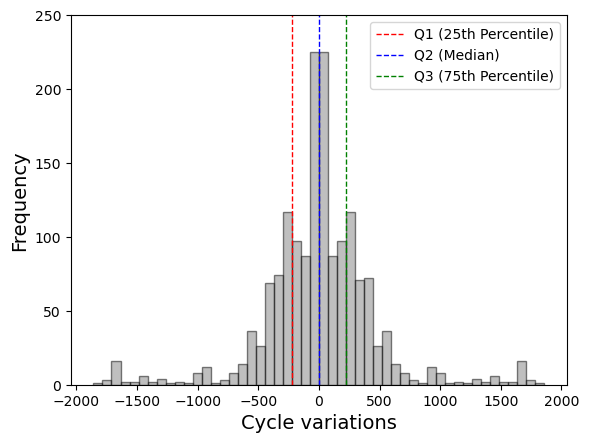

In [12]:
import matplotlib.pyplot as plt

# Your data
data = [ts[0].item() for ts in tensors_y]

# Calculate quartiles
q1 = np.percentile(data, 25)
q2 = np.percentile(data, 50)
q3 = np.percentile(data, 75)

# Plot histogram
plt.hist(data, bins=50, alpha=0.5, color='grey', edgecolor='black')

# Add quartile lines
plt.axvline(x=q1, color='r', linestyle='--', linewidth=1, label='Q1 (25th Percentile)')
plt.axvline(x=q2, color='b', linestyle='--', linewidth=1, label='Q2 (Median)')
plt.axvline(x=q3, color='g', linestyle='--', linewidth=1, label='Q3 (75th Percentile)')

# Adding labels and legend
plt.xlabel('Cycle variations', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.ylim(0,250)
plt.show()

# Show plot
plt.show()

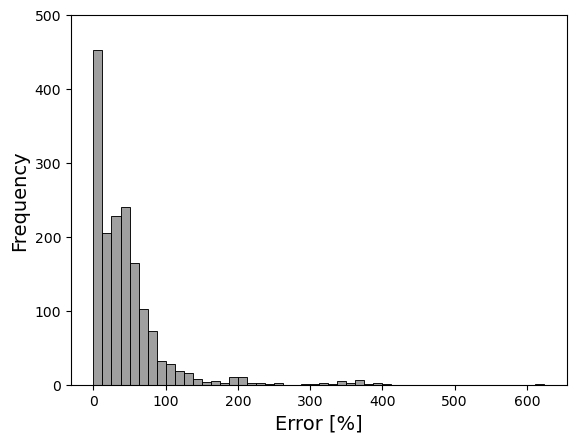

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(total_train_dist_err, kde=False, color='grey', bins=50)
plt.xlabel('Error [%]', fontsize=14)
plt.ylim(0,500)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [14]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
    
class MLP(nn.Module):
    def __init__(self, input_size=visible, hidden_size=5):
        super(MLP, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(visible, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1)
        )            
            
    def forward(self, x):
        return self.net(x)
    
from torchsummary import summary
mlp = MLP(visible, 5)
if torch.cuda.is_available(): mlp.cuda()
summary(mlp, (visible,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 5]                   1,505
|    └─LeakyReLU: 2-2                    [-1, 5]                   --
|    └─Linear: 2-3                       [-1, 5]                   30
|    └─LeakyReLU: 2-4                    [-1, 5]                   --
|    └─Linear: 2-5                       [-1, 5]                   30
|    └─LeakyReLU: 2-6                    [-1, 5]                   --
|    └─Linear: 2-7                       [-1, 5]                   30
|    └─LeakyReLU: 2-8                    [-1, 5]                   --
|    └─Linear: 2-9                       [-1, 1]                   6
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 5]                   1,505
|    └─LeakyReLU: 2-2                    [-1, 5]                   --
|    └─Linear: 2-3                       [-1, 5]                   30
|    └─LeakyReLU: 2-4                    [-1, 5]                   --
|    └─Linear: 2-5                       [-1, 5]                   30
|    └─LeakyReLU: 2-6                    [-1, 5]                   --
|    └─Linear: 2-7                       [-1, 5]                   30
|    └─LeakyReLU: 2-8                    [-1, 5]                   --
|    └─Linear: 2-9                       [-1, 1]                   6
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [15]:
def train_loss_function(x, y, w):
    loss = F.mse_loss(x, y, reduction='none')
    loss = w*loss
    return loss.sum()

def loss_function(x, y):
    loss = F.mse_loss(x, y, reduction='sum')
    return loss

def early_stop(patience, step, train_patience):
    if step > patience:
        train_cnt = 0
        for k in range(len(train_patience) - 1):
            if train_patience[k] < train_patience[k + 1]:
                train_cnt += 1
            elif abs(train_patience[k]- train_patience[k + 1]) < 1e-6:
                train_cnt += 1                
        if train_cnt == (patience-1):
            return True
    else:
        return False
    
def grid_stop(patience, grid_step, grid_patience):
    if grid_step > patience:
        grid_cnt = 0
        for k in range(len(grid_patience) - 1):
            if grid_patience[k] < grid_patience[k + 1]:
                grid_cnt += 1
            elif abs(grid_patience[k] - grid_patience[k + 1]) < 1e-2:
                grid_cnt += 1                
        if grid_cnt == (patience-1):
            return True
    else:
        return False
    
def train(mlp, train_loader):
    mlp.train()
    train_loss = 0
    
    for batch_idx, (data, label, err_weight) in enumerate(train_loader):
        data = data.cuda()
        label = label.cuda()
        err_weight = err_weight.cuda()
        optimizer.zero_grad()
        
        predicted = mlp(data)
        loss = train_loss_function(predicted, label, err_weight)
        loss.backward()  
        
        train_loss += loss.item()
        optimizer.step()
   
    return train_loss / len(train_loader.dataset)
    
def test(mlp, test_data_loader):
    mlp.eval()
    test_loss = 0
    # This is valid when test_data_loader size is less than 10
    with torch.no_grad():
        for data, label in test_data_loader:
            data = data.cuda()
            label = label.cuda()
            correction_factors = mlp(data)
            test_loss += loss_function(correction_factors, label).item()
    
    return correction_factors, test_loss 

def set_seed_everywhere(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [16]:
from collections import deque

## Grid search with training samples
grid_hidden_size = [c for c in range(5, 105, 5)]
grid_epochs = [c for c in range(100, 505, 5)]
grid_errs = {}
prev_err = 1e4
curr_err = 1e4
for hiden_step, ghs in enumerate(grid_hidden_size):
    g_patience = 5
    grid_patience = deque(maxlen=g_patience)
    hidden_size = ghs
    gridStop = False
    for grid_step, ge in enumerate(grid_epochs):
        # For training
        errors = []
        epochs = ge
        patience = 10
        train_patience = deque(maxlen=patience)
        train_loader = train_data_loader
        set_seed_everywhere(seed=42)
        mlp = MLP(visible, hidden_size)
        if torch.cuda.is_available():
            mlp.cuda()
        optimizer = optim.Adam(mlp.parameters(), lr=0.0001, weight_decay=0.0001)
        earlyStopped = False
        print('\n', 'epoch: ', ge, ', hidden_size: ', ghs)
        for epoch in range(epochs):
            tloss = train(mlp, train_loader)
            errors.append(tloss)
            # Save early stop model
            train_patience.append(tloss)
            torch.save(mlp.state_dict(), f"model_epoch_{epoch%patience}.pt")
            if early_stop(patience, epoch, train_patience): 
                print("=======Early Stop!========")
                earlyStopped = True
                optim_step = (epoch+1)%patience
                break

        # Load early stop model
        if earlyStopped:
            print("=======Load the early stop agent!========")
            state_dict = torch.load(f"model_epoch_{optim_step}.pt")
            mlp = MLP(visible*2, hidden_size)
            if torch.cuda.is_available():
                mlp.cuda()
            mlp.load_state_dict(state_dict)

        ## Apply Correction Factor to train Samples
        train_corrction_cycles = []
        train_corrected_cycles = []
        corrected_train_error_cycle = []
        corrected_train_percentage_error = []

        train_loader_for_valid = train_data_loader_for_valid
        train_correction_factors, train_error = test(mlp, train_loader_for_valid)

        if norm_method == 'minimax': 
            cf = train_correction_factors
            cf = (cf + norm_scale) / (2*norm_scale)
            cf = cf*(max_tensor_y - min_tensor_y) + min_tensor_y
            train_corrction_cycles = cf
        elif norm_method == 'standard': 
            train_corrction_cycles = train_correction_factors*std_tensor_y + mean_tensor_y
        elif norm_method == 'robust':
            train_corrction_cycles = train_correction_factors*iqr_tensor_y + median_tensor_y            

        cc = copy.deepcopy(train_corrction_cycles)
        train_corrected_cycles = cc.cpu() + torch.stack([torch.from_numpy(arr) for arr in train_expected_eol_cycle])
        train_label = train_visible_dataset_y
        for i in range(len(train_label)):
            corrected_train_error_cycle.append(train_corrected_cycles[i] - train_label[i])
            corrected_train_percentage_error.append(abs(corrected_train_error_cycle[i]/train_label[i]) * 100)

        print('\nTotal train Avg Error:', np.mean([arr for arr in train_percentage_error]), '[%]')
        print('Total train Std of Errors:', np.std([arr for arr in train_percentage_error]), '[%]')

        mean = torch.mean(torch.stack([arr for arr in corrected_train_percentage_error])).item()
        std = torch.std(torch.stack([arr for arr in corrected_train_percentage_error])).item()
        square_mean = torch.mean(torch.stack([arr**2 for arr in corrected_train_error_cycle])).item()
        sqrt = np.sqrt(square_mean)
        
        curr_err = mean
        grid_patience.append(curr_err)
        if grid_stop(patience, grid_step, grid_patience): continue
        if curr_err < prev_err or curr_err < 7.5:
            grid_errs[(epochs, hidden_size)] = curr_err
            prev_err = curr_err
            print(grid_errs)
                
        print('Total train Corrected Avg Error:', round(mean, 2), '[%]')
        print('Total train Corrected Std of Errors:', round(std, 2), '[%]')
        print('Total train Corrected RMSE :', round(sqrt, 0), '[cycles]\n')


 epoch:  100 , hidden_size:  5

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071}
Total train Corrected Avg Error: 14.54 [%]
Total train Corrected Std of Errors: 13.22 [%]
Total train Corrected RMSE : 195.0 [cycles]


 epoch:  105 , hidden_size:  5

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917}
Total train Corrected Avg Error: 14.18 [%]
Total train Corrected Std of Errors: 13.34 [%]
Total train Corrected RMSE : 194.0 [cycles]


 epoch:  110 , hidden_size:  5

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917, (110, 5): 13.892748245319805}
Total train Corrected Avg Error: 13.89 [%]
Total train Corrected Std of Errors: 13.41 [%]
Total train Corrected RMSE : 193.0 [cycles]


 epoch:  115 , hidden_size:


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917, (110, 5): 13.892748245319805, (115, 5): 13.651232834951166, (120, 5): 13.479427429219834, (125, 5): 13.31116901858917, (130, 5): 13.080530533849801, (135, 5): 12.921278998764121, (140, 5): 12.850977776759626, (145, 5): 12.71286940597082, (150, 5): 12.561731226760896, (155, 5): 12.483962687746033, (160, 5): 12.421448416908982, (165, 5): 12.279819775920812, (170, 5): 12.219509152690286, (175, 5): 12.11481253374455, (180, 5): 12.062664613792085}
Total train Corrected Avg Error: 12.06 [%]
Total train Corrected Std of Errors: 14.19 [%]
Total train Corrected RMSE : 187.0 [cycles]


 epoch:  185 , hidden_size:  5

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917, (110, 5): 13.892748245319805, (115, 5): 13.651232834951166, (120, 5): 13


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917, (110, 5): 13.892748245319805, (115, 5): 13.651232834951166, (120, 5): 13.479427429219834, (125, 5): 13.31116901858917, (130, 5): 13.080530533849801, (135, 5): 12.921278998764121, (140, 5): 12.850977776759626, (145, 5): 12.71286940597082, (150, 5): 12.561731226760896, (155, 5): 12.483962687746033, (160, 5): 12.421448416908982, (165, 5): 12.279819775920812, (170, 5): 12.219509152690286, (175, 5): 12.11481253374455, (180, 5): 12.062664613792085, (185, 5): 11.970587589523292, (190, 5): 11.907979093786043, (195, 5): 11.799515080027815, (200, 5): 11.705559037218617, (205, 5): 11.55621840291862, (210, 5): 11.432960954230957, (215, 5): 11.281223238132675, (220, 5): 11.10768791884383, (225, 5): 10.921038482401391, (230, 5): 10.754322025937588}
Total train Corrected Avg Error: 10.75 [%]
Total train Corrected Std of Errors: 13.61 [%]
Total tr


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917, (110, 5): 13.892748245319805, (115, 5): 13.651232834951166, (120, 5): 13.479427429219834, (125, 5): 13.31116901858917, (130, 5): 13.080530533849801, (135, 5): 12.921278998764121, (140, 5): 12.850977776759626, (145, 5): 12.71286940597082, (150, 5): 12.561731226760896, (155, 5): 12.483962687746033, (160, 5): 12.421448416908982, (165, 5): 12.279819775920812, (170, 5): 12.219509152690286, (175, 5): 12.11481253374455, (180, 5): 12.062664613792085, (185, 5): 11.970587589523292, (190, 5): 11.907979093786043, (195, 5): 11.799515080027815, (200, 5): 11.705559037218617, (205, 5): 11.55621840291862, (210, 5): 11.432960954230957, (215, 5): 11.281223238132675, (220, 5): 11.10768791884383, (225, 5): 10.921038482401391, (230, 5): 10.754322025937588, (235, 5): 10.605674712425516, (240, 5): 10.420845492669045, (245, 5): 10.28791028495777, (250, 5):


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917, (110, 5): 13.892748245319805, (115, 5): 13.651232834951166, (120, 5): 13.479427429219834, (125, 5): 13.31116901858917, (130, 5): 13.080530533849801, (135, 5): 12.921278998764121, (140, 5): 12.850977776759626, (145, 5): 12.71286940597082, (150, 5): 12.561731226760896, (155, 5): 12.483962687746033, (160, 5): 12.421448416908982, (165, 5): 12.279819775920812, (170, 5): 12.219509152690286, (175, 5): 12.11481253374455, (180, 5): 12.062664613792085, (185, 5): 11.970587589523292, (190, 5): 11.907979093786043, (195, 5): 11.799515080027815, (200, 5): 11.705559037218617, (205, 5): 11.55621840291862, (210, 5): 11.432960954230957, (215, 5): 11.281223238132675, (220, 5): 11.10768791884383, (225, 5): 10.921038482401391, (230, 5): 10.754322025937588, (235, 5): 10.605674712425516, (240, 5): 10.420845492669045, (245, 5): 10.28791028495777, (250, 5):


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917, (110, 5): 13.892748245319805, (115, 5): 13.651232834951166, (120, 5): 13.479427429219834, (125, 5): 13.31116901858917, (130, 5): 13.080530533849801, (135, 5): 12.921278998764121, (140, 5): 12.850977776759626, (145, 5): 12.71286940597082, (150, 5): 12.561731226760896, (155, 5): 12.483962687746033, (160, 5): 12.421448416908982, (165, 5): 12.279819775920812, (170, 5): 12.219509152690286, (175, 5): 12.11481253374455, (180, 5): 12.062664613792085, (185, 5): 11.970587589523292, (190, 5): 11.907979093786043, (195, 5): 11.799515080027815, (200, 5): 11.705559037218617, (205, 5): 11.55621840291862, (210, 5): 11.432960954230957, (215, 5): 11.281223238132675, (220, 5): 11.10768791884383, (225, 5): 10.921038482401391, (230, 5): 10.754322025937588, (235, 5): 10.605674712425516, (240, 5): 10.420845492669045, (245, 5): 10.28791028495777, (250, 5):


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917, (110, 5): 13.892748245319805, (115, 5): 13.651232834951166, (120, 5): 13.479427429219834, (125, 5): 13.31116901858917, (130, 5): 13.080530533849801, (135, 5): 12.921278998764121, (140, 5): 12.850977776759626, (145, 5): 12.71286940597082, (150, 5): 12.561731226760896, (155, 5): 12.483962687746033, (160, 5): 12.421448416908982, (165, 5): 12.279819775920812, (170, 5): 12.219509152690286, (175, 5): 12.11481253374455, (180, 5): 12.062664613792085, (185, 5): 11.970587589523292, (190, 5): 11.907979093786043, (195, 5): 11.799515080027815, (200, 5): 11.705559037218617, (205, 5): 11.55621840291862, (210, 5): 11.432960954230957, (215, 5): 11.281223238132675, (220, 5): 11.10768791884383, (225, 5): 10.921038482401391, (230, 5): 10.754322025937588, (235, 5): 10.605674712425516, (240, 5): 10.420845492669045, (245, 5): 10.28791028495777, (250, 5):


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 8.92 [%]
Total train Corrected Std of Errors: 12.41 [%]
Total train Corrected RMSE : 174.0 [cycles]


 epoch:  425 , hidden_size:  5

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
{(100, 5): 14.542183687426071, (105, 5): 14.177885295008917, (110, 5): 13.892748245319805, (115, 5): 13.651232834951166, (120, 5): 13.479427429219834, (125, 5): 13.31116901858917, (130, 5): 13.080530533849801, (135, 5): 12.921278998764121, (140, 5): 12.850977776759626, (145, 5): 12.71286940597082, (150, 5): 12.561731226760896, (155, 5): 12.483962687746033, (160, 5): 12.421448416908982, (165, 5): 12.279819775920812, (170, 5): 12.219509152690286, (175, 5): 12.11481253374455, (180, 5): 12.062664613792085, (185, 5): 11.970587589523292, (190, 5): 11.907979093786043, (195, 5): 11.799515080027815, (200, 5): 11.705559037218617, (205, 5): 11.5


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.33 [%]
Total train Corrected Std of Errors: 13.45 [%]
Total train Corrected RMSE : 184.0 [cycles]


 epoch:  115 , hidden_size:  10

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.05 [%]
Total train Corrected Std of Errors: 13.45 [%]
Total train Corrected RMSE : 183.0 [cycles]


 epoch:  120 , hidden_size:  10

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.98 [%]
Total train Corrected Std of Errors: 13.44 [%]
Total train Corrected RMSE : 183.0 [cycles]


 epoch:  125 , hidden_size:  10

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.26 [%]
Total train Corrected Std of Errors: 13.38 [%]
Total train Corrected R


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.17 [%]
Total train Corrected Std of Errors: 12.66 [%]
Total train Corrected RMSE : 180.0 [cycles]


 epoch:  275 , hidden_size:  10

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.28 [%]
Total train Corrected Std of Errors: 12.69 [%]
Total train Corrected RMSE : 180.0 [cycles]


 epoch:  280 , hidden_size:  10

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.31 [%]
Total train Corrected Std of Errors: 12.71 [%]
Total train Corrected RMSE : 180.0 [cycles]


 epoch:  285 , hidden_size:  10

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.53 [%]
Total train Corrected Std of Errors: 12.88 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.01 [%]
Total train Corrected Std of Errors: 13.12 [%]
Total train Corrected RMSE : 180.0 [cycles]


 epoch:  435 , hidden_size:  10

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.68 [%]
Total train Corrected Std of Errors: 12.79 [%]
Total train Corrected RMSE : 178.0 [cycles]


 epoch:  440 , hidden_size:  10

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.71 [%]
Total train Corrected Std of Errors: 12.88 [%]
Total train Corrected RMSE : 178.0 [cycles]


 epoch:  445 , hidden_size:  10

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.53 [%]
Total train Corrected Std of Errors: 12.74 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.78 [%]
Total train Corrected Std of Errors: 13.31 [%]
Total train Corrected RMSE : 178.0 [cycles]


 epoch:  190 , hidden_size:  15

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.75 [%]
Total train Corrected Std of Errors: 13.41 [%]
Total train Corrected RMSE : 178.0 [cycles]


 epoch:  195 , hidden_size:  15

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.77 [%]
Total train Corrected Std of Errors: 13.45 [%]
Total train Corrected RMSE : 179.0 [cycles]


 epoch:  200 , hidden_size:  15

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.79 [%]
Total train Corrected Std of Errors: 13.37 [%]
Total train Corrected RMSE


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.95 [%]
Total train Corrected Std of Errors: 12.93 [%]
Total train Corrected RMSE : 176.0 [cycles]


 epoch:  350 , hidden_size:  15

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.0 [%]
Total train Corrected Std of Errors: 13.19 [%]
Total train Corrected RMSE : 178.0 [cycles]


 epoch:  355 , hidden_size:  15

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.98 [%]
Total train Corrected Std of Errors: 12.92 [%]
Total train Corrected RMSE : 176.0 [cycles]


 epoch:  360 , hidden_size:  15

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.05 [%]
Total train Corrected Std of Errors: 12.95 [%]
Total train Corrected RMS


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.99 [%]
Total train Corrected Std of Errors: 13.43 [%]
Total train Corrected RMSE : 178.0 [cycles]


 epoch:  105 , hidden_size:  20

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.31 [%]
Total train Corrected Std of Errors: 13.39 [%]
Total train Corrected RMSE : 179.0 [cycles]


 epoch:  110 , hidden_size:  20

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.46 [%]
Total train Corrected Std of Errors: 14.19 [%]
Total train Corrected RMSE : 179.0 [cycles]


 epoch:  115 , hidden_size:  20

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.48 [%]
Total train Corrected Std of Errors: 13.85 [%]
Total train Corrected R


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.49 [%]
Total train Corrected Std of Errors: 12.86 [%]
Total train Corrected RMSE : 177.0 [cycles]


 epoch:  265 , hidden_size:  20

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.62 [%]
Total train Corrected Std of Errors: 12.7 [%]
Total train Corrected RMSE : 177.0 [cycles]


 epoch:  270 , hidden_size:  20

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.07 [%]
Total train Corrected Std of Errors: 12.7 [%]
Total train Corrected RMSE : 176.0 [cycles]


 epoch:  275 , hidden_size:  20

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.66 [%]
Total train Corrected Std of Errors: 12.7 [%]
Total train Corrected RMSE :


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.07 [%]
Total train Corrected Std of Errors: 12.48 [%]
Total train Corrected RMSE : 174.0 [cycles]


 epoch:  425 , hidden_size:  20

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.77 [%]
Total train Corrected Std of Errors: 12.46 [%]
Total train Corrected RMSE : 174.0 [cycles]


 epoch:  430 , hidden_size:  20

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.78 [%]
Total train Corrected Std of Errors: 12.16 [%]
Total train Corrected RMSE : 173.0 [cycles]


 epoch:  435 , hidden_size:  20

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.2 [%]
Total train Corrected Std of Errors: 12.2 [%]
Total train Corrected RMSE


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.15 [%]
Total train Corrected Std of Errors: 12.99 [%]
Total train Corrected RMSE : 174.0 [cycles]


 epoch:  180 , hidden_size:  25

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.17 [%]
Total train Corrected Std of Errors: 12.93 [%]
Total train Corrected RMSE : 172.0 [cycles]


 epoch:  185 , hidden_size:  25

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.16 [%]
Total train Corrected Std of Errors: 12.92 [%]
Total train Corrected RMSE : 172.0 [cycles]


 epoch:  190 , hidden_size:  25

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.09 [%]
Total train Corrected Std of Errors: 12.64 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.32 [%]
Total train Corrected Std of Errors: 11.82 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  340 , hidden_size:  25

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.14 [%]
Total train Corrected Std of Errors: 11.81 [%]
Total train Corrected RMSE : 169.0 [cycles]


 epoch:  345 , hidden_size:  25

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.11 [%]
Total train Corrected Std of Errors: 11.78 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  350 , hidden_size:  25

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.18 [%]
Total train Corrected Std of Errors: 11.55 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.58 [%]
Total train Corrected Std of Errors: 11.64 [%]
Total train Corrected RMSE : 165.0 [cycles]


 epoch:  500 , hidden_size:  25

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.09 [%]
Total train Corrected Std of Errors: 12.08 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  100 , hidden_size:  30

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.65 [%]
Total train Corrected Std of Errors: 13.12 [%]
Total train Corrected RMSE : 176.0 [cycles]


 epoch:  105 , hidden_size:  30

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.0 [%]
Total train Corrected Std of Errors: 13.56 [%]
Total train Corrected R


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.69 [%]
Total train Corrected Std of Errors: 13.99 [%]
Total train Corrected RMSE : 174.0 [cycles]


 epoch:  255 , hidden_size:  30

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.9 [%]
Total train Corrected Std of Errors: 14.62 [%]
Total train Corrected RMSE : 175.0 [cycles]


 epoch:  260 , hidden_size:  30

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.59 [%]
Total train Corrected Std of Errors: 13.92 [%]
Total train Corrected RMSE : 174.0 [cycles]


 epoch:  265 , hidden_size:  30

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.76 [%]
Total train Corrected Std of Errors: 14.25 [%]
Total train Corrected R


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.44 [%]
Total train Corrected Std of Errors: 13.25 [%]
Total train Corrected RMSE : 170.0 [cycles]


 epoch:  415 , hidden_size:  30

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.18 [%]
Total train Corrected Std of Errors: 11.98 [%]
Total train Corrected RMSE : 169.0 [cycles]


 epoch:  420 , hidden_size:  30

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.68 [%]
Total train Corrected Std of Errors: 11.65 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  425 , hidden_size:  30

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.08 [%]
Total train Corrected Std of Errors: 11.53 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.71 [%]
Total train Corrected Std of Errors: 12.23 [%]
Total train Corrected RMSE : 170.0 [cycles]


 epoch:  170 , hidden_size:  35

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.6 [%]
Total train Corrected Std of Errors: 12.3 [%]
Total train Corrected RMSE : 171.0 [cycles]


 epoch:  175 , hidden_size:  35

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.59 [%]
Total train Corrected Std of Errors: 12.54 [%]
Total train Corrected RMSE : 172.0 [cycles]


 epoch:  180 , hidden_size:  35

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.62 [%]
Total train Corrected Std of Errors: 13.02 [%]
Total train Corrected RMSE 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.59 [%]
Total train Corrected Std of Errors: 12.55 [%]
Total train Corrected RMSE : 169.0 [cycles]


 epoch:  330 , hidden_size:  35

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.4 [%]
Total train Corrected Std of Errors: 12.41 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  335 , hidden_size:  35

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.75 [%]
Total train Corrected Std of Errors: 11.8 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  340 , hidden_size:  35

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.0 [%]
Total train Corrected Std of Errors: 11.36 [%]
Total train Corrected RMSE


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.14 [%]
Total train Corrected Std of Errors: 11.09 [%]
Total train Corrected RMSE : 163.0 [cycles]


 epoch:  490 , hidden_size:  35

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.86 [%]
Total train Corrected Std of Errors: 13.01 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  495 , hidden_size:  35

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.93 [%]
Total train Corrected Std of Errors: 11.79 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  500 , hidden_size:  35

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.93 [%]
Total train Corrected Std of Errors: 11.09 [%]
Total train Corrected RM


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.3 [%]
Total train Corrected Std of Errors: 12.85 [%]
Total train Corrected RMSE : 174.0 [cycles]


 epoch:  245 , hidden_size:  40

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.89 [%]
Total train Corrected Std of Errors: 12.2 [%]
Total train Corrected RMSE : 171.0 [cycles]


 epoch:  250 , hidden_size:  40

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.83 [%]
Total train Corrected Std of Errors: 13.83 [%]
Total train Corrected RMSE : 174.0 [cycles]


 epoch:  255 , hidden_size:  40

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.17 [%]
Total train Corrected Std of Errors: 11.99 [%]
Total train Corrected RMS


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.68 [%]
Total train Corrected Std of Errors: 13.76 [%]
Total train Corrected RMSE : 171.0 [cycles]


 epoch:  405 , hidden_size:  40

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.17 [%]
Total train Corrected Std of Errors: 12.13 [%]
Total train Corrected RMSE : 169.0 [cycles]


 epoch:  410 , hidden_size:  40

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.72 [%]
Total train Corrected Std of Errors: 12.1 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  415 , hidden_size:  40

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.6 [%]
Total train Corrected Std of Errors: 11.41 [%]
Total train Corrected RM


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.99 [%]
Total train Corrected Std of Errors: 12.13 [%]
Total train Corrected RMSE : 172.0 [cycles]


 epoch:  160 , hidden_size:  45

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.92 [%]
Total train Corrected Std of Errors: 12.03 [%]
Total train Corrected RMSE : 171.0 [cycles]


 epoch:  165 , hidden_size:  45

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.0 [%]
Total train Corrected Std of Errors: 12.33 [%]
Total train Corrected RMSE : 172.0 [cycles]


 epoch:  170 , hidden_size:  45

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.99 [%]
Total train Corrected Std of Errors: 12.31 [%]
Total train Corrected RMSE


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.62 [%]
Total train Corrected Std of Errors: 12.49 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  320 , hidden_size:  45

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.56 [%]
Total train Corrected Std of Errors: 11.89 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  325 , hidden_size:  45

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.68 [%]
Total train Corrected Std of Errors: 13.51 [%]
Total train Corrected RMSE : 169.0 [cycles]


 epoch:  330 , hidden_size:  45

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.66 [%]
Total train Corrected Std of Errors: 11.7 [%]
Total train Corrected R


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.31 [%]
Total train Corrected Std of Errors: 11.08 [%]
Total train Corrected RMSE : 162.0 [cycles]


 epoch:  480 , hidden_size:  45

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.23 [%]
Total train Corrected Std of Errors: 11.42 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  485 , hidden_size:  45

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.97 [%]
Total train Corrected Std of Errors: 11.3 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  490 , hidden_size:  45

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.28 [%]
Total train Corrected Std of Errors: 10.88 [%]
Total train Corrected R


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.04 [%]
Total train Corrected Std of Errors: 11.69 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  235 , hidden_size:  50

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.07 [%]
Total train Corrected Std of Errors: 11.48 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  240 , hidden_size:  50

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.47 [%]
Total train Corrected Std of Errors: 12.59 [%]
Total train Corrected RMSE : 170.0 [cycles]


 epoch:  245 , hidden_size:  50

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.28 [%]
Total train Corrected Std of Errors: 11.87 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.91 [%]
Total train Corrected Std of Errors: 11.0 [%]
Total train Corrected RMSE : 163.0 [cycles]


 epoch:  395 , hidden_size:  50

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.81 [%]
Total train Corrected Std of Errors: 11.06 [%]
Total train Corrected RMSE : 163.0 [cycles]


 epoch:  400 , hidden_size:  50

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.82 [%]
Total train Corrected Std of Errors: 11.16 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  405 , hidden_size:  50

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.9 [%]
Total train Corrected Std of Errors: 11.37 [%]
Total train Corrected RMSE :


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.09 [%]
Total train Corrected Std of Errors: 12.37 [%]
Total train Corrected RMSE : 173.0 [cycles]


 epoch:  150 , hidden_size:  55

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.03 [%]
Total train Corrected Std of Errors: 12.46 [%]
Total train Corrected RMSE : 174.0 [cycles]


 epoch:  155 , hidden_size:  55

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.95 [%]
Total train Corrected Std of Errors: 12.42 [%]
Total train Corrected RMSE : 173.0 [cycles]


 epoch:  160 , hidden_size:  55

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.31 [%]
Total train Corrected Std of Errors: 12.57 [%]
Total train Corrected R


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.89 [%]
Total train Corrected Std of Errors: 11.8 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  310 , hidden_size:  55

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.88 [%]
Total train Corrected Std of Errors: 11.51 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  315 , hidden_size:  55

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.95 [%]
Total train Corrected Std of Errors: 11.37 [%]
Total train Corrected RMSE : 166.0 [cycles]


 epoch:  320 , hidden_size:  55

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.04 [%]
Total train Corrected Std of Errors: 11.3 [%]
Total train Corrected RMSE 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.78 [%]
Total train Corrected Std of Errors: 10.93 [%]
Total train Corrected RMSE : 161.0 [cycles]


 epoch:  470 , hidden_size:  55

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.87 [%]
Total train Corrected Std of Errors: 10.77 [%]
Total train Corrected RMSE : 160.0 [cycles]


 epoch:  475 , hidden_size:  55

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.65 [%]
Total train Corrected Std of Errors: 10.83 [%]
Total train Corrected RMSE : 160.0 [cycles]


 epoch:  480 , hidden_size:  55

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.8 [%]
Total train Corrected Std of Errors: 11.5 [%]
Total train Corrected RMSE :


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.72 [%]
Total train Corrected Std of Errors: 11.67 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  225 , hidden_size:  60

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.21 [%]
Total train Corrected Std of Errors: 11.73 [%]
Total train Corrected RMSE : 169.0 [cycles]


 epoch:  230 , hidden_size:  60

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.26 [%]
Total train Corrected Std of Errors: 11.67 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  235 , hidden_size:  60

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.87 [%]
Total train Corrected Std of Errors: 11.77 [%]
Total train Corrected RM


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.83 [%]
Total train Corrected Std of Errors: 11.36 [%]
Total train Corrected RMSE : 161.0 [cycles]


 epoch:  385 , hidden_size:  60

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.98 [%]
Total train Corrected Std of Errors: 10.96 [%]
Total train Corrected RMSE : 161.0 [cycles]


 epoch:  390 , hidden_size:  60

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.28 [%]
Total train Corrected Std of Errors: 11.18 [%]
Total train Corrected RMSE : 161.0 [cycles]


 epoch:  395 , hidden_size:  60

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.67 [%]
Total train Corrected Std of Errors: 10.1 [%]
Total train Corrected RMSE


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.94 [%]
Total train Corrected Std of Errors: 12.06 [%]
Total train Corrected RMSE : 171.0 [cycles]


 epoch:  140 , hidden_size:  65

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.04 [%]
Total train Corrected Std of Errors: 12.4 [%]
Total train Corrected RMSE : 172.0 [cycles]


 epoch:  145 , hidden_size:  65

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.23 [%]
Total train Corrected Std of Errors: 12.45 [%]
Total train Corrected RMSE : 173.0 [cycles]


 epoch:  150 , hidden_size:  65

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.55 [%]
Total train Corrected Std of Errors: 13.12 [%]
Total train Corrected RM


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.83 [%]
Total train Corrected Std of Errors: 11.08 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  300 , hidden_size:  65

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.54 [%]
Total train Corrected Std of Errors: 11.08 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  305 , hidden_size:  65

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.7 [%]
Total train Corrected Std of Errors: 11.37 [%]
Total train Corrected RMSE : 165.0 [cycles]


 epoch:  310 , hidden_size:  65

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.1 [%]
Total train Corrected Std of Errors: 11.42 [%]
Total train Corrected RMSE


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.59 [%]
Total train Corrected Std of Errors: 10.84 [%]
Total train Corrected RMSE : 159.0 [cycles]


 epoch:  460 , hidden_size:  65

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.24 [%]
Total train Corrected Std of Errors: 11.35 [%]
Total train Corrected RMSE : 162.0 [cycles]


 epoch:  465 , hidden_size:  65

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.77 [%]
Total train Corrected Std of Errors: 10.67 [%]
Total train Corrected RMSE : 158.0 [cycles]


 epoch:  470 , hidden_size:  65

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.64 [%]
Total train Corrected Std of Errors: 10.46 [%]
Total train Corrected RMS


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.19 [%]
Total train Corrected Std of Errors: 12.78 [%]
Total train Corrected RMSE : 170.0 [cycles]


 epoch:  215 , hidden_size:  70

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.1 [%]
Total train Corrected Std of Errors: 12.57 [%]
Total train Corrected RMSE : 170.0 [cycles]


 epoch:  220 , hidden_size:  70

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.47 [%]
Total train Corrected Std of Errors: 12.65 [%]
Total train Corrected RMSE : 171.0 [cycles]


 epoch:  225 , hidden_size:  70

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.31 [%]
Total train Corrected Std of Errors: 12.09 [%]
Total train Corrected R


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.16 [%]
Total train Corrected Std of Errors: 11.37 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  375 , hidden_size:  70

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.02 [%]
Total train Corrected Std of Errors: 11.25 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  380 , hidden_size:  70

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.16 [%]
Total train Corrected Std of Errors: 12.51 [%]
Total train Corrected RMSE : 166.0 [cycles]


 epoch:  385 , hidden_size:  70

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.14 [%]
Total train Corrected Std of Errors: 11.41 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.54 [%]
Total train Corrected Std of Errors: 12.04 [%]
Total train Corrected RMSE : 169.0 [cycles]


 epoch:  130 , hidden_size:  75

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 11.31 [%]
Total train Corrected Std of Errors: 13.29 [%]
Total train Corrected RMSE : 177.0 [cycles]


 epoch:  135 , hidden_size:  75

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.79 [%]
Total train Corrected Std of Errors: 13.55 [%]
Total train Corrected RMSE : 173.0 [cycles]


 epoch:  140 , hidden_size:  75

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.29 [%]
Total train Corrected Std of Errors: 12.05 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.68 [%]
Total train Corrected Std of Errors: 11.06 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  290 , hidden_size:  75

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.48 [%]
Total train Corrected Std of Errors: 11.55 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  295 , hidden_size:  75

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.61 [%]
Total train Corrected Std of Errors: 10.94 [%]
Total train Corrected RMSE : 162.0 [cycles]


 epoch:  300 , hidden_size:  75

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.62 [%]
Total train Corrected Std of Errors: 11.82 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.58 [%]
Total train Corrected Std of Errors: 10.61 [%]
Total train Corrected RMSE : 157.0 [cycles]


 epoch:  450 , hidden_size:  75

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.8 [%]
Total train Corrected Std of Errors: 11.01 [%]
Total train Corrected RMSE : 160.0 [cycles]


 epoch:  455 , hidden_size:  75

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.28 [%]
Total train Corrected Std of Errors: 10.63 [%]
Total train Corrected RMSE : 157.0 [cycles]


 epoch:  460 , hidden_size:  75

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.92 [%]
Total train Corrected Std of Errors: 10.91 [%]
Total train Corrected RMSE 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.64 [%]
Total train Corrected Std of Errors: 12.52 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  205 , hidden_size:  80

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.19 [%]
Total train Corrected Std of Errors: 11.79 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  210 , hidden_size:  80

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.18 [%]
Total train Corrected Std of Errors: 12.25 [%]
Total train Corrected RMSE : 166.0 [cycles]


 epoch:  215 , hidden_size:  80

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.32 [%]
Total train Corrected Std of Errors: 12.31 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.95 [%]
Total train Corrected Std of Errors: 10.69 [%]
Total train Corrected RMSE : 159.0 [cycles]


 epoch:  365 , hidden_size:  80

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.86 [%]
Total train Corrected Std of Errors: 10.65 [%]
Total train Corrected RMSE : 159.0 [cycles]


 epoch:  370 , hidden_size:  80

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.84 [%]
Total train Corrected Std of Errors: 10.59 [%]
Total train Corrected RMSE : 158.0 [cycles]


 epoch:  375 , hidden_size:  80

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.72 [%]
Total train Corrected Std of Errors: 10.56 [%]
Total train Corrected RMSE


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.6 [%]
Total train Corrected Std of Errors: 12.43 [%]
Total train Corrected RMSE : 171.0 [cycles]


 epoch:  120 , hidden_size:  85

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.76 [%]
Total train Corrected Std of Errors: 12.52 [%]
Total train Corrected RMSE : 172.0 [cycles]


 epoch:  125 , hidden_size:  85

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.23 [%]
Total train Corrected Std of Errors: 12.43 [%]
Total train Corrected RMSE : 170.0 [cycles]


 epoch:  130 , hidden_size:  85

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.34 [%]
Total train Corrected Std of Errors: 12.11 [%]
Total train Corrected R


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.04 [%]
Total train Corrected Std of Errors: 11.13 [%]
Total train Corrected RMSE : 164.0 [cycles]


 epoch:  280 , hidden_size:  85

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.45 [%]
Total train Corrected Std of Errors: 10.95 [%]
Total train Corrected RMSE : 163.0 [cycles]


 epoch:  285 , hidden_size:  85

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.73 [%]
Total train Corrected Std of Errors: 11.77 [%]
Total train Corrected RMSE : 166.0 [cycles]


 epoch:  290 , hidden_size:  85

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.61 [%]
Total train Corrected Std of Errors: 11.04 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.69 [%]
Total train Corrected Std of Errors: 10.37 [%]
Total train Corrected RMSE : 156.0 [cycles]


 epoch:  440 , hidden_size:  85

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.27 [%]
Total train Corrected Std of Errors: 11.02 [%]
Total train Corrected RMSE : 158.0 [cycles]


 epoch:  445 , hidden_size:  85

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.58 [%]
Total train Corrected Std of Errors: 10.72 [%]
Total train Corrected RMSE : 159.0 [cycles]


 epoch:  450 , hidden_size:  85

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.39 [%]
Total train Corrected Std of Errors: 10.82 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.85 [%]
Total train Corrected Std of Errors: 12.78 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  195 , hidden_size:  90

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.69 [%]
Total train Corrected Std of Errors: 11.26 [%]
Total train Corrected RMSE : 165.0 [cycles]


 epoch:  200 , hidden_size:  90

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.67 [%]
Total train Corrected Std of Errors: 11.37 [%]
Total train Corrected RMSE : 165.0 [cycles]


 epoch:  205 , hidden_size:  90

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.26 [%]
Total train Corrected Std of Errors: 11.07 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.2 [%]
Total train Corrected Std of Errors: 11.0 [%]
Total train Corrected RMSE : 159.0 [cycles]


 epoch:  355 , hidden_size:  90

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.98 [%]
Total train Corrected Std of Errors: 11.14 [%]
Total train Corrected RMSE : 162.0 [cycles]


 epoch:  360 , hidden_size:  90

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.24 [%]
Total train Corrected Std of Errors: 11.0 [%]
Total train Corrected RMSE : 161.0 [cycles]


 epoch:  365 , hidden_size:  90

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.91 [%]
Total train Corrected Std of Errors: 10.75 [%]
Total train Corrected RMSE 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.91 [%]
Total train Corrected Std of Errors: 11.65 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  110 , hidden_size:  95

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.3 [%]
Total train Corrected Std of Errors: 12.09 [%]
Total train Corrected RMSE : 170.0 [cycles]


 epoch:  115 , hidden_size:  95

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.49 [%]
Total train Corrected Std of Errors: 11.87 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  120 , hidden_size:  95

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.27 [%]
Total train Corrected Std of Errors: 12.3 [%]
Total train Corrected RM


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.23 [%]
Total train Corrected Std of Errors: 11.43 [%]
Total train Corrected RMSE : 163.0 [cycles]


 epoch:  270 , hidden_size:  95

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.4 [%]
Total train Corrected Std of Errors: 10.73 [%]
Total train Corrected RMSE : 159.0 [cycles]


 epoch:  275 , hidden_size:  95

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.28 [%]
Total train Corrected Std of Errors: 11.19 [%]
Total train Corrected RMSE : 163.0 [cycles]


 epoch:  280 , hidden_size:  95

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.11 [%]
Total train Corrected Std of Errors: 10.67 [%]
Total train Corrected RM


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.52 [%]
Total train Corrected Std of Errors: 10.33 [%]
Total train Corrected RMSE : 158.0 [cycles]


 epoch:  430 , hidden_size:  95

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.38 [%]
Total train Corrected Std of Errors: 10.73 [%]
Total train Corrected RMSE : 159.0 [cycles]


 epoch:  435 , hidden_size:  95

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.93 [%]
Total train Corrected Std of Errors: 11.32 [%]
Total train Corrected RMSE : 156.0 [cycles]


 epoch:  440 , hidden_size:  95

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.45 [%]
Total train Corrected Std of Errors: 11.09 [%]
Total train Corrected RM


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.51 [%]
Total train Corrected Std of Errors: 12.4 [%]
Total train Corrected RMSE : 168.0 [cycles]


 epoch:  185 , hidden_size:  100

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.27 [%]
Total train Corrected Std of Errors: 11.73 [%]
Total train Corrected RMSE : 167.0 [cycles]


 epoch:  190 , hidden_size:  100

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.97 [%]
Total train Corrected Std of Errors: 11.38 [%]
Total train Corrected RMSE : 165.0 [cycles]


 epoch:  195 , hidden_size:  100

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.92 [%]
Total train Corrected Std of Errors: 11.45 [%]
Total train Corrected 


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.46 [%]
Total train Corrected Std of Errors: 10.59 [%]
Total train Corrected RMSE : 157.0 [cycles]


 epoch:  340 , hidden_size:  100

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.91 [%]
Total train Corrected Std of Errors: 10.55 [%]
Total train Corrected RMSE : 157.0 [cycles]


 epoch:  345 , hidden_size:  100

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.15 [%]
Total train Corrected Std of Errors: 10.88 [%]
Total train Corrected RMSE : 157.0 [cycles]


 epoch:  350 , hidden_size:  100

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 10.98 [%]
Total train Corrected Std of Errors: 12.1 [%]
Total train Corrected


Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.12 [%]
Total train Corrected Std of Errors: 10.47 [%]
Total train Corrected RMSE : 148.0 [cycles]


 epoch:  500 , hidden_size:  100

Total train Avg Error: 12.40510912255159 [%]
Total train Std of Errors: 15.390487914011597 [%]
Total train Corrected Avg Error: 9.47 [%]
Total train Corrected Std of Errors: 9.82 [%]
Total train Corrected RMSE : 146.0 [cycles]



In [17]:
grid_errs

{(100, 5): 14.542183687426071,
 (105, 5): 14.177885295008917,
 (110, 5): 13.892748245319805,
 (115, 5): 13.651232834951166,
 (120, 5): 13.479427429219834,
 (125, 5): 13.31116901858917,
 (130, 5): 13.080530533849801,
 (135, 5): 12.921278998764121,
 (140, 5): 12.850977776759626,
 (145, 5): 12.71286940597082,
 (150, 5): 12.561731226760896,
 (155, 5): 12.483962687746033,
 (160, 5): 12.421448416908982,
 (165, 5): 12.279819775920812,
 (170, 5): 12.219509152690286,
 (175, 5): 12.11481253374455,
 (180, 5): 12.062664613792085,
 (185, 5): 11.970587589523292,
 (190, 5): 11.907979093786043,
 (195, 5): 11.799515080027815,
 (200, 5): 11.705559037218617,
 (205, 5): 11.55621840291862,
 (210, 5): 11.432960954230957,
 (215, 5): 11.281223238132675,
 (220, 5): 11.10768791884383,
 (225, 5): 10.921038482401391,
 (230, 5): 10.754322025937588,
 (235, 5): 10.605674712425516,
 (240, 5): 10.420845492669045,
 (245, 5): 10.28791028495777,
 (250, 5): 10.156750605045396,
 (255, 5): 10.03692744413116,
 (260, 5): 9.95

In [18]:
## Find the minimum value in the grid_errors dictionary
min_value = min(grid_errs.values())  
epochs, hidden_size = [e for (e, value) in grid_errs.items() if value == min_value][0]
print('best epoch:', epochs, ', best hidden size:', hidden_size)

best epoch: 435 , best hidden size: 5


In [19]:
from collections import deque

## Train mlp with best epoch and hidden_size obtained from grid search
errors = []
train_loader = train_data_loader
set_seed_everywhere(seed=42)
mlp = MLP(visible, hidden_size)
if torch.cuda.is_available():
    mlp.cuda()
optimizer = optim.Adam(mlp.parameters(), lr=0.0001, weight_decay=0.0001)
for epoch in range(epochs):
    tloss = train(mlp, train_loader)
    errors.append(tloss)

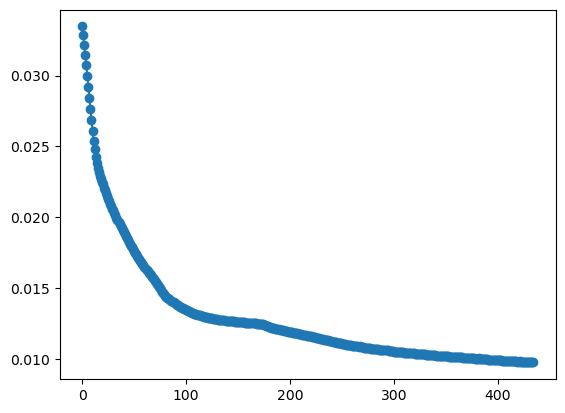

In [20]:
plt.plot(range(len(errors)), errors, marker='o')

In [21]:
## Apply Correction Factor to primary Samples
primary_corrction_cycles = []
primary_corrected_cycles = []
corrected_primary_error_cycle = []
corrected_primary_percentage_error = []

primary_loader = primary_data_loader
primary_correction_factors, primary_error = test(mlp, primary_loader)

if norm_method == 'minimax': 
    cf = primary_correction_factors
    cf = (cf + norm_scale) / (2*norm_scale)
    cf = cf*(max_tensor_y - min_tensor_y) + min_tensor_y
    primary_corrction_cycles = cf
elif norm_method == 'standard': 
    primary_corrction_cycles = primary_correction_factors*std_tensor_y + mean_tensor_y
elif norm_method == 'robust': 
    primary_corrction_cycles = primary_correction_factors*iqr_tensor_y + median_tensor_y

cc = copy.deepcopy(primary_corrction_cycles)
primary_corrected_cycles = cc.cpu() + torch.stack([torch.from_numpy(arr) for arr in primary_expected_eol_cycle])
primary_label = primary_visible_dataset_y
for i in range(len(primary_label)):
    corrected_primary_error_cycle.append(primary_corrected_cycles[i] - primary_label[i])
    corrected_primary_percentage_error.append(abs(corrected_primary_error_cycle[i]/primary_label[i]) * 100)
        
print('\nTotal primary Avg Error:', round(np.mean([arr for arr in primary_percentage_error]), 2), '[%]')
print('Total primary Std of Errors:', round(np.std([arr for arr in primary_percentage_error]), 2), '[%]')
print('Total primary RMSE:', round(total_primary_rmse[0]), '[cycles]')

mean = torch.mean(torch.stack([arr for arr in corrected_primary_percentage_error])).item()
std = torch.std(torch.stack([arr for arr in corrected_primary_percentage_error])).item()
square_mean = torch.mean(torch.stack([err**2 for err in corrected_primary_error_cycle])).item()
sqrt = np.sqrt(square_mean)
print('\nTotal primary Corrected Avg Error:', round(mean, 2), '[%]')
print('Total primary Corrected Std of Errors:', round(std, 2), '[%]')
print('Total primary Corrected RMSE:', round(sqrt), '[cycles]')


Total primary Avg Error: 9.66 [%]
Total primary Std of Errors: 10.55 [%]
Total primary RMSE: 116 [cycles]

Total primary Corrected Avg Error: 7.16 [%]
Total primary Corrected Std of Errors: 7.15 [%]
Total primary Corrected RMSE: 105 [cycles]


In [22]:
## Apply Correction Factor to secondary Samples
secondary_corrction_cycles = []
secondary_corrected_cycles = []
corrected_secondary_error_cycle = []
corrected_secondary_percentage_error = []

secondary_loader = secondary_data_loader
secondary_correction_factors, secondary_error = test(mlp, secondary_loader)

if norm_method == 'minimax': 
    cf = secondary_correction_factors
    cf = (cf + norm_scale) / (2*norm_scale)
    cf = cf*(max_tensor_y - min_tensor_y) + min_tensor_y
    secondary_corrction_cycles = cf
elif norm_method == 'standard': 
    secondary_corrction_cycles = secondary_correction_factors*std_tensor_y + mean_tensor_y
elif norm_method == 'robust':
    secondary_corrction_cycles = secondary_correction_factors*iqr_tensor_y + median_tensor_y
    
    
cc = copy.deepcopy(secondary_corrction_cycles)
secondary_corrected_cycles = cc.cpu() + torch.stack([torch.from_numpy(arr) for arr in secondary_expected_eol_cycle])
secondary_label = secondary_visible_dataset_y
for i in range(len(secondary_label)):
    corrected_secondary_error_cycle.append(secondary_corrected_cycles[i] - secondary_label[i])
    corrected_secondary_percentage_error.append(abs(corrected_secondary_error_cycle[i]/secondary_label[i]) * 100)
        
print('\nTotal secondary Avg Error:', round(np.mean([arr for arr in secondary_percentage_error]), 2), '[%]')
print('Total secondary Std of Errors:', round(np.std([arr for arr in secondary_percentage_error]), 2), '[%]')
print('Total secondary RMSE:', round(total_secondary_rmse[0]), '[cycles]')

mean = torch.mean(torch.stack([arr for arr in corrected_secondary_percentage_error])).item()
std = torch.std(torch.stack([arr for arr in corrected_secondary_percentage_error])).item()
square_mean = torch.mean(torch.stack([err**2 for err in corrected_secondary_error_cycle])).item()
sqrt = np.sqrt(square_mean)
print('\nTotal secondary Corrected Avg Error:', round(mean, 2), '[%]')
print('Total secondary Corrected Std of Errors:', round(std, 2), '[%]')
print('Total primary Corrected RMSE:', round(sqrt), '[cycles]')


Total secondary Avg Error: 22.09 [%]
Total secondary Std of Errors: 30.44 [%]
Total secondary RMSE: 377 [cycles]

Total secondary Corrected Avg Error: 21.88 [%]
Total secondary Corrected Std of Errors: 30.37 [%]
Total primary Corrected RMSE: 375 [cycles]


In [23]:
# Errors before and after applying the correction factor to primary samples
print('###################### Primary Samples ######################')
print('Before Correct', '\t\t', 'After Correct', '\t\t', 'Improvement\n')
errsum = []
for i, (fst, snd) in enumerate(zip(primary_percentage_error, corrected_primary_percentage_error)):
    errsum.append(fst-snd.item())
    print('{:.2f}'.format(fst[0]), '\t\t', '{:.2f}'.format(snd.item()), '\t\t', '{:.2f}'.format((fst-snd.item())[0]), '\t\tsample {}'.format(i))

###################### Primary Samples ######################
Before Correct 		 After Correct 		 Improvement

22.59 		 23.02 		 -0.43 		sample 0
3.45 		 3.06 		 0.38 		sample 1
16.11 		 15.98 		 0.13 		sample 2
22.71 		 10.59 		 12.13 		sample 3
18.73 		 17.16 		 1.57 		sample 4
18.34 		 16.62 		 1.72 		sample 5
16.63 		 12.69 		 3.94 		sample 6
23.80 		 19.96 		 3.84 		sample 7
16.92 		 8.09 		 8.83 		sample 8
0.30 		 2.36 		 -2.06 		sample 9
13.15 		 12.27 		 0.87 		sample 10
3.33 		 0.91 		 2.42 		sample 11
5.14 		 8.75 		 -3.62 		sample 12
19.11 		 14.80 		 4.30 		sample 13
6.36 		 4.40 		 1.96 		sample 14
5.56 		 4.08 		 1.48 		sample 15
21.67 		 19.59 		 2.09 		sample 16
1.28 		 1.51 		 -0.23 		sample 17
8.10 		 9.74 		 -1.64 		sample 18
5.39 		 7.12 		 -1.73 		sample 19
2.85 		 1.33 		 1.51 		sample 20
52.85 		 5.57 		 47.29 		sample 21
1.46 		 1.00 		 0.46 		sample 22
0.36 		 4.63 		 -4.28 		sample 23
3.07 		 4.10 		 -1.03 		sample 24
0.41 		 0.75 		 -0.34 		sample 25
14.85 		 

In [24]:
# Errors before and after applying the correction factor to secondary samples
print('###################### Secondary Samples ######################')
print('Before Correct', '\t\t', 'After Correct', '\t\t', 'Improvement\n')
errsum = []
for i, (fst, snd) in enumerate(zip(secondary_percentage_error, corrected_secondary_percentage_error)):
    errsum.append(fst-snd.item())
    print('{:.2f}'.format(fst[0]), '\t\t', '{:.2f}'.format(snd.item()), '\t\t', '{:.2f}'.format((fst-snd.item())[0]), '\t\tsample {}'.format(i))

###################### Secondary Samples ######################
Before Correct 		 After Correct 		 Improvement

0.79 		 0.13 		 0.66 		sample 0
9.14 		 13.52 		 -4.38 		sample 1
8.81 		 10.25 		 -1.44 		sample 2
2.96 		 3.43 		 -0.46 		sample 3
11.74 		 19.02 		 -7.28 		sample 4
30.98 		 25.03 		 5.95 		sample 5
17.67 		 16.89 		 0.78 		sample 6
16.71 		 10.67 		 6.04 		sample 7
108.10 		 106.99 		 1.11 		sample 8
5.67 		 6.59 		 -0.92 		sample 9
10.55 		 10.95 		 -0.40 		sample 10
132.04 		 131.60 		 0.44 		sample 11
13.14 		 16.10 		 -2.95 		sample 12
18.57 		 20.06 		 -1.48 		sample 13
0.69 		 6.27 		 -5.58 		sample 14
37.96 		 38.38 		 -0.42 		sample 15
18.35 		 19.45 		 -1.09 		sample 16
24.13 		 27.02 		 -2.89 		sample 17
24.72 		 26.62 		 -1.90 		sample 18
18.87 		 12.88 		 5.98 		sample 19
27.66 		 14.79 		 12.87 		sample 20
1.50 		 0.52 		 0.98 		sample 21
30.26 		 19.46 		 10.79 		sample 22
2.84 		 1.67 		 1.17 		sample 23
1.07 		 0.06 		 1.01 		sample 24
2.36 		 5.49 		 -3.1

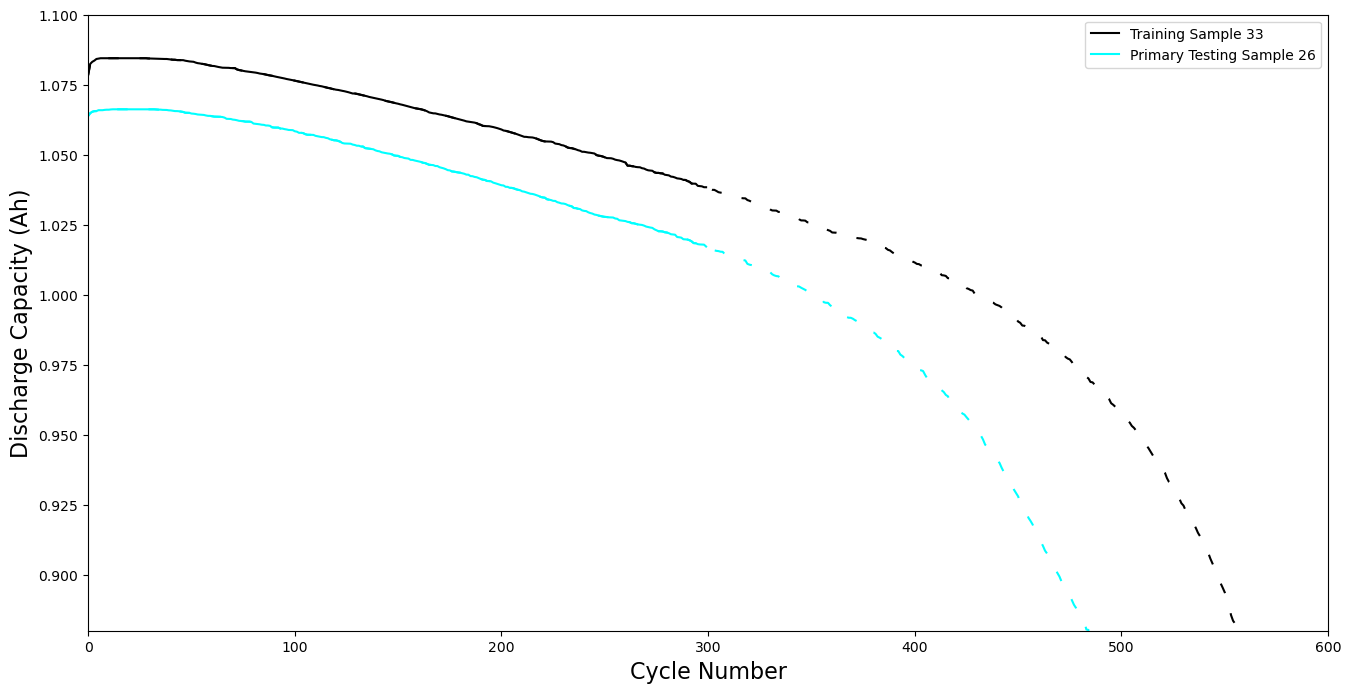

In [25]:
# Image used in Figure 5
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(len(primary_test_dataset)):
    if i == 26:
        ax.plot(range(len(train_dataset[primary_min_indices[i]][:])), train_dataset[primary_min_indices[i]][:], color='black', linestyle=(0, (5, 10)), lw='1.5')
        ax.plot(range(len(primary_test_dataset[i][:])), primary_test_dataset[i][:], color='cyan', linestyle=(0, (5, 10)), lw='1.5')

        ax.plot(range(len(train_dataset[primary_min_indices[i]][:visible])), train_dataset[primary_min_indices[i]][:visible], color='black', lw='1.5', label='Training Sample 33')
        ax.plot(range(len(primary_test_dataset[i][:visible])), primary_test_dataset[i][:visible], color='cyan', lw='1.5', label='Primary Testing Sample 26')

        ax.set_xlabel('Cycle Number', fontsize=16)
        ax.set_ylabel('Discharge Capacity (Ah)', fontsize=16)
        ax.set_ylim(0.88, 1.1)
        ax.set_xlim(0, 600)
        ax.legend()
        
# plt.savefig('Cosine Similarity Limit', format='png', dpi=300)